In [782]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf

In [783]:
df_train = pd.read_csv("../data/train.csv")
X_sub = pd.read_csv("../data/test.csv")

In [784]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15709511.0,Ch'ang,754.0,Spain,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Genovese,579.0,France,Female,28.0,1.0,0.00,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Yeh,744.0,France,Female,56.0,5.0,0.00,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Nwachinemelu,697.0,France,Male,29.0,2.0,0.00,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Hs?eh,628.0,France,Female,22.0,9.0,0.00,2.0,1.0,0.0,49653.39,0.0


### Dropping columns
Drop id and CustomerId columns as they will not be usefull for analysis. Let's drop Surname as it does not bring value for now, we need to somehow process it first.

In [785]:
df_train = df_train.drop(columns=['id', 'CustomerId', 'Surname'], errors='ignore')
df_test = df_test.drop(columns=['id', 'CustomerId', 'Surname'], errors='ignore')

### Train test split

In [786]:
X = df_train.drop(columns='Exited')
y = df_train['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)
Xy_train = X_train.copy()
Xy_train['Exited'] = y_train

### Input features
There are no null values in the dataset.  
There are 6 categorical features: Geography, Gender, NumOfProducts, HasCrCard, IsActiveMember.  
There are 4 numerical features: CreditScore, Age, Tenure, Balance, EstimatedSalary.

In [787]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10050 entries, 8638 to 11605
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10050 non-null  float64
 1   Geography        10050 non-null  object 
 2   Gender           10050 non-null  object 
 3   Age              10050 non-null  float64
 4   Tenure           10050 non-null  float64
 5   Balance          10050 non-null  float64
 6   NumOfProducts    10050 non-null  float64
 7   HasCrCard        10050 non-null  float64
 8   IsActiveMember   10050 non-null  float64
 9   EstimatedSalary  10050 non-null  float64
dtypes: float64(8), object(2)
memory usage: 863.7+ KB


In [788]:
categ_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary']

### Target distribution
Target class is inbalanced, but the evaluation is the ROC AUC, so it is okay.

In [789]:
y_train.value_counts()

Exited
0.0    8032
1.0    2018
Name: count, dtype: int64

### Numerical features distributions

Estimated salary has outliers.

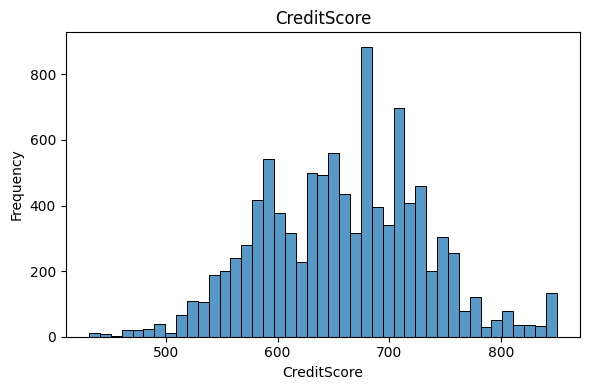

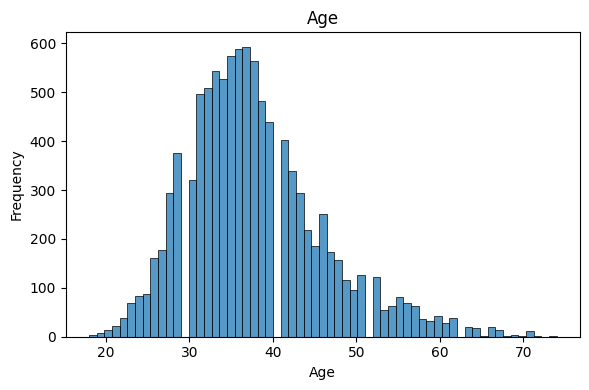

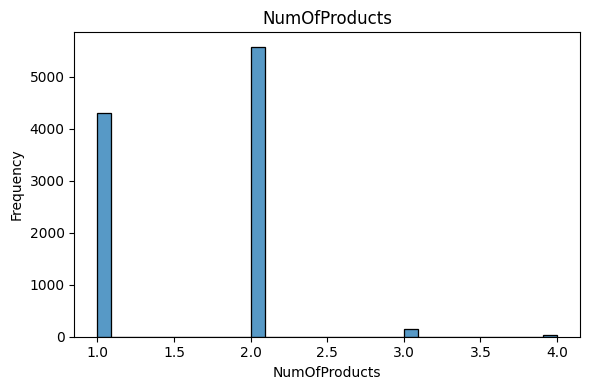

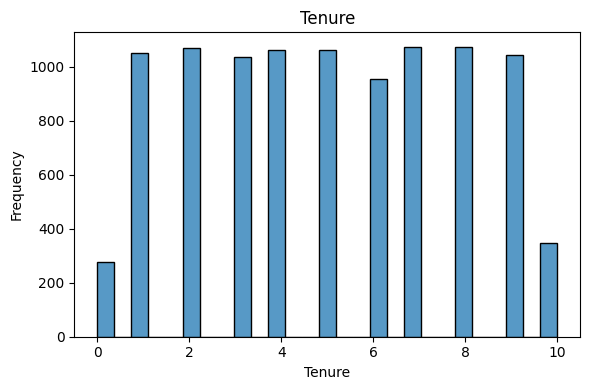

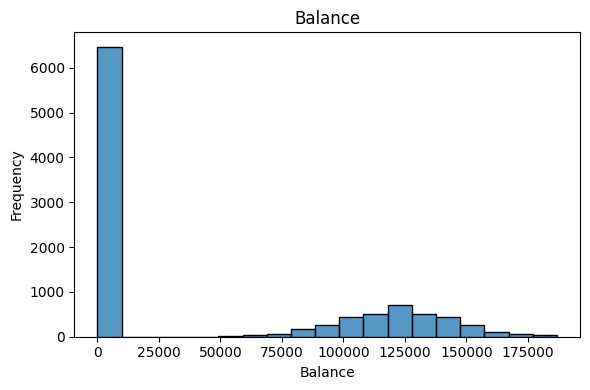

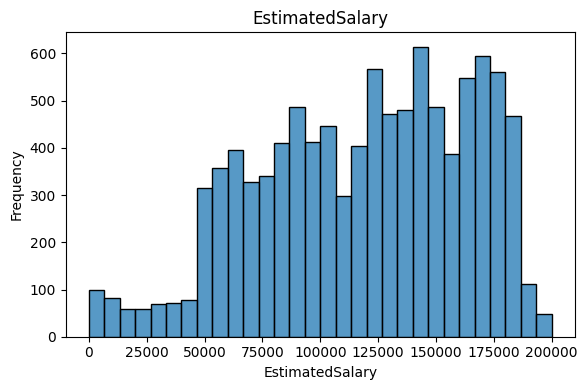

In [790]:
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_train[col])
    plt.title(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [791]:
df_train.sort_values("EstimatedSalary").iloc[-10:, :]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9799,554.0,Germany,Female,51.0,9.0,92350.37,1.0,1.0,0.0,199693.84,1.0
4355,611.0,France,Female,46.0,7.0,0.00,1.0,1.0,0.0,199805.63,1.0
13855,611.0,France,Male,42.0,4.0,0.00,2.0,1.0,1.0,199808.10,0.0
415,679.0,France,Female,42.0,2.0,0.00,2.0,1.0,1.0,199808.10,0.0
3336,663.0,France,Female,34.0,3.0,152582.30,1.0,0.0,1.0,199808.10,0.0
8950,663.0,Germany,Male,33.0,7.0,141787.31,2.0,1.0,0.0,199953.33,0.0
2862,613.0,Spain,Male,44.0,3.0,166082.15,1.0,1.0,0.0,199953.33,0.0
14472,699.0,France,Male,30.0,8.0,0.00,2.0,0.0,1.0,199953.33,0.0
12815,587.0,Germany,Female,63.0,9.0,128663.90,1.0,1.0,0.0,199992.48,1.0
377,837.0,France,Male,34.0,8.0,160515.37,1.0,1.0,1.0,1557802.42,0.0


Let's drop this outlier row:

In [792]:
X_train = X_train.drop(labels=377, errors='ignore')
y_train = y_train.drop(labels=377, errors='ignore')
X_test = X_test.drop(labels=377, errors='ignore')
y_test = y_test.drop(labels=377, errors='ignore')

Correlations between features for entries with non-zero balance.

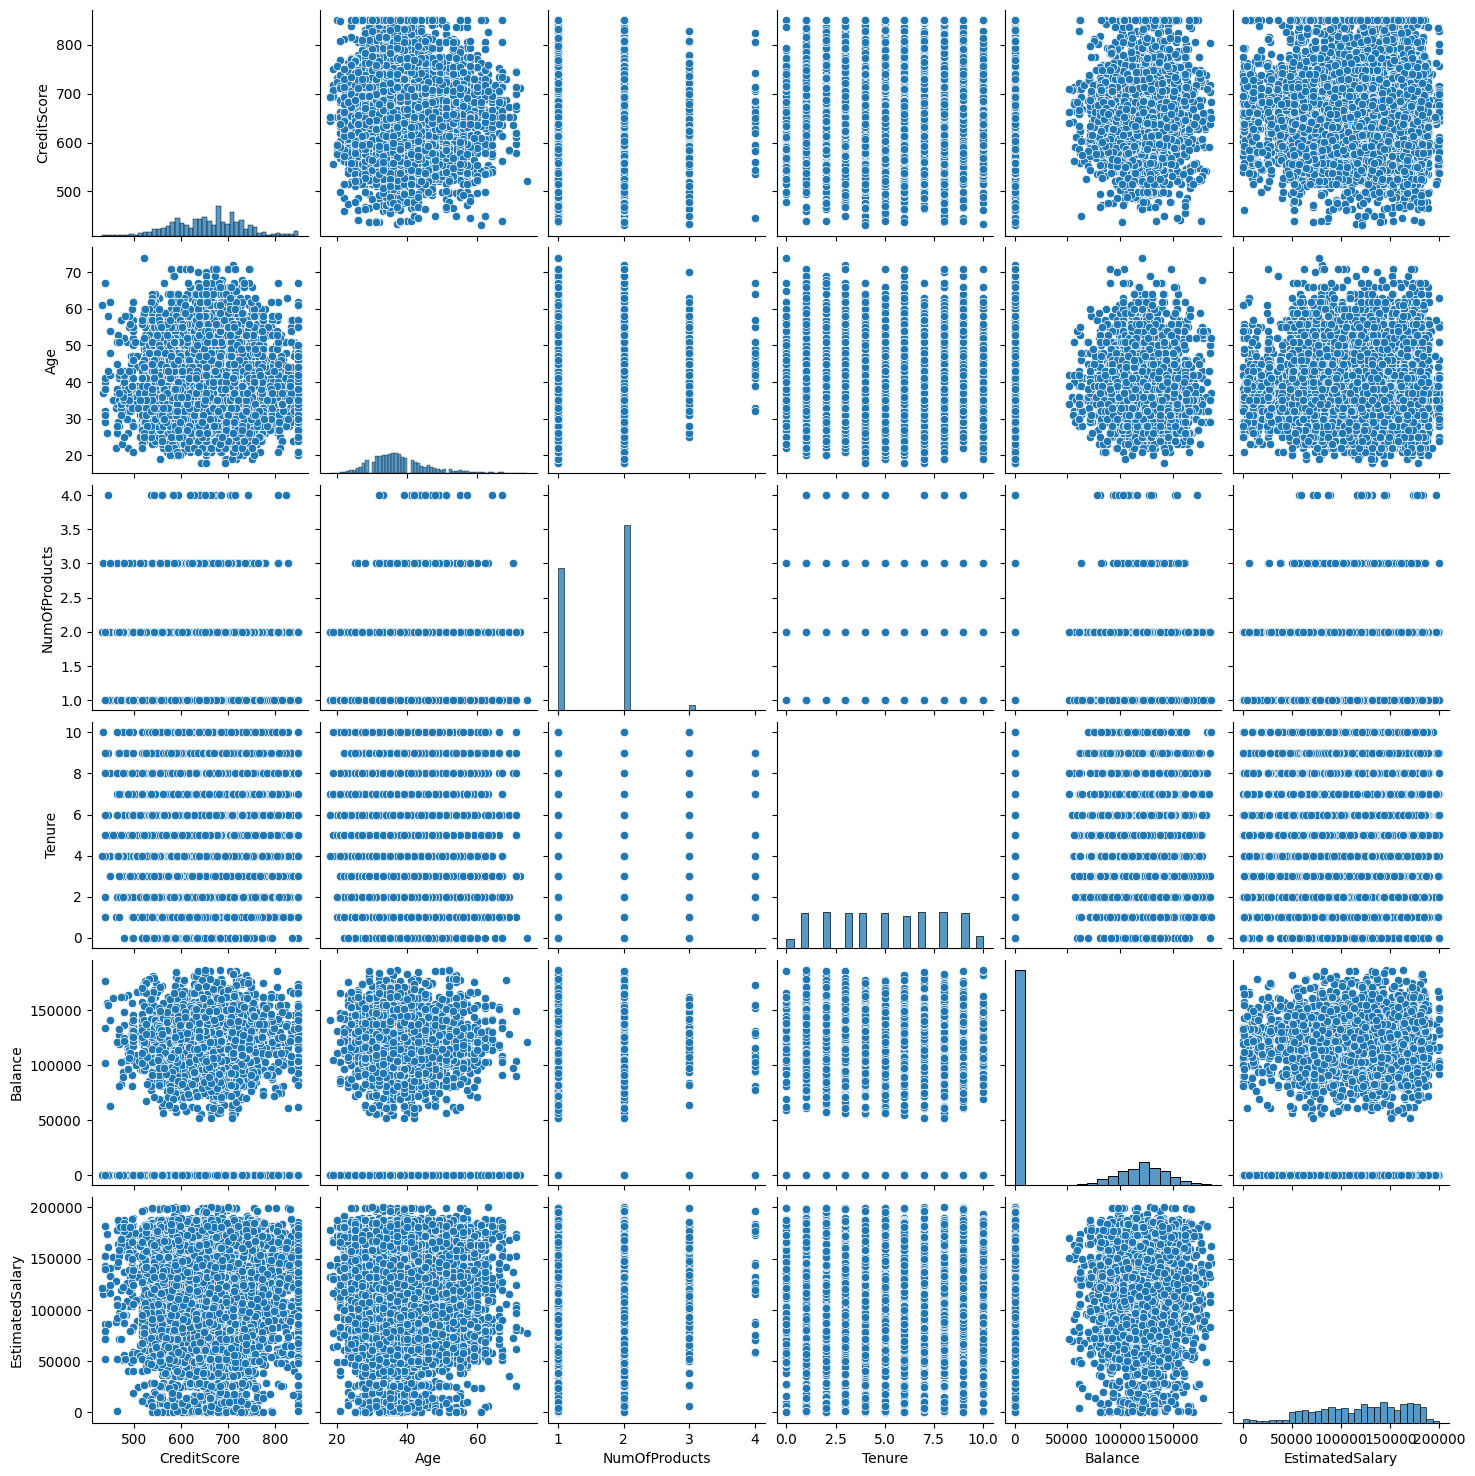

In [793]:
sns.pairplot(X_train[numeric_features])


### Categorical features distributions

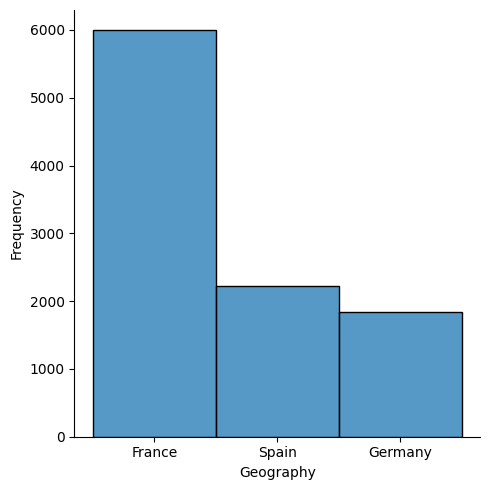

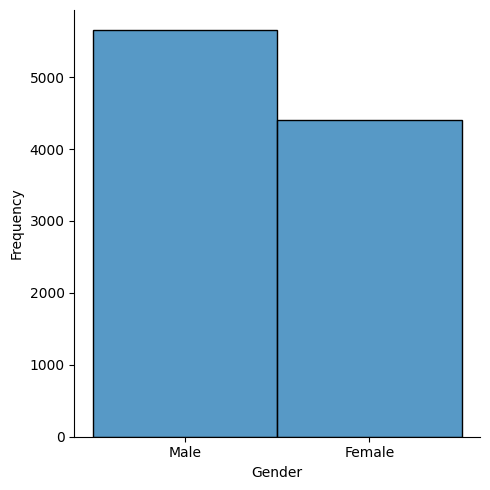

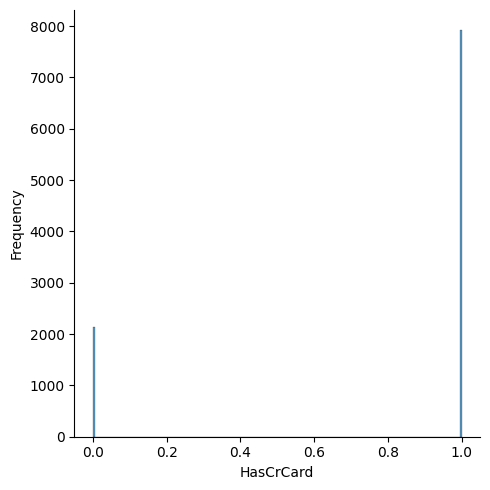

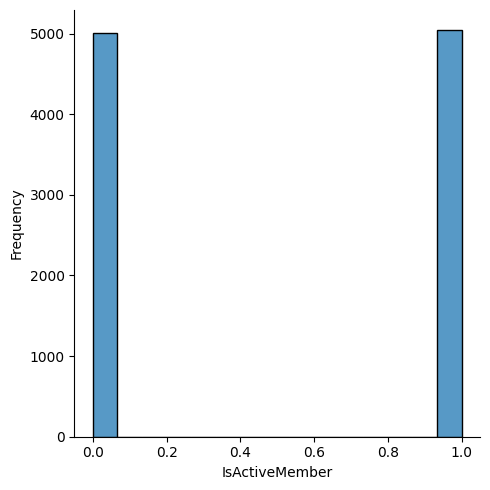

In [794]:
for col in categ_features:
    plt.Figure(figsize=(4,6))
    sns.displot(X_train, x=col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Churn rate in Germany is much higher than in France and Spain.

In [795]:
Xy_train.groupby(by='Geography').agg(
    count=('Exited', 'size'),
    count_exited=('Exited', lambda x: (x == 1).sum()),
    count_not_exited=('Exited', lambda x: (x == 0).sum()),
    churn_rate=('Exited', 'mean')
)

,count,count_exited,count_not_exited,churn_rate
Geography,,,,
France,5994,922,5072,0.153820
Germany,1840,748,1092,0.406522
Spain,2216,348,1868,0.157040


### Correlation

Metrics are not correlated much between each other.

In [796]:
Xy_train.corr(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.035314,0.013570,-0.001522,0.012331,0.002297,0.009454,-0.020591,-0.047528
Age,-0.035314,1.000000,-0.004056,0.083508,-0.158515,-0.000728,-0.059967,0.006526,0.487361
Tenure,0.013570,-0.004056,1.000000,-0.018392,0.012660,0.016508,-0.013211,-0.001134,-0.013445
Balance,-0.001522,0.083508,-0.018392,1.000000,-0.412968,-0.006790,-0.021883,0.016099,0.150709
NumOfProducts,0.012331,-0.158515,0.012660,-0.412968,1.000000,0.022120,0.050138,0.006577,-0.278894
HasCrCard,0.002297,-0.000728,0.016508,-0.006790,0.022120,1.000000,-0.014171,-0.023856,-0.030446
IsActiveMember,0.009454,-0.059967,-0.013211,-0.021883,0.050138,-0.014171,1.000000,-0.000610,-0.209745
EstimatedSalary,-0.020591,0.006526,-0.001134,0.016099,0.006577,-0.023856,-0.000610,1.000000,0.017401
Exited,-0.047528,0.487361,-0.013445,0.150709,-0.278894,-0.030446,-0.209745,0.017401,1.000000


### Standartization and one-hot encoding

In [797]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

,copy,True
,with_mean,True
,with_std,True


In [798]:
print(scaler.mean_)

[6.58810746e+02 3.78791045e+01 1.59253731e+00 5.02955224e+00
 4.34104940e+04 1.18337558e+05]


In [799]:
X_train[numeric_features] = scaler.transform(X_train[numeric_features])

In [800]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8638,-0.993979,France,Male,2.930160,1.060361,-0.725027,-1.105649,0.0,1.0,0.182383
11606,0.528602,France,Male,-0.106792,1.060361,-0.725027,-1.105649,1.0,0.0,-2.558114
9521,-0.135797,France,Female,1.107989,0.346421,-0.725027,0.760308,1.0,0.0,0.168997
12807,1.317576,Spain,Male,0.865033,-0.010549,1.130501,-1.105649,1.0,1.0,-0.431240
14338,1.428309,Germany,Male,0.986511,-0.010549,1.793513,0.760308,1.0,0.0,-2.189715


In [801]:
enc_features = ['Geography']
enc = OneHotEncoder()

In [802]:
enc.fit(X_train[enc_features])

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [803]:
encoded_array = enc.transform(X_train[enc_features]).toarray()

In [804]:
encoded_names = enc.get_feature_names_out(enc_features)
print (encoded_names)

['Geography_France' 'Geography_Germany' 'Geography_Spain']


In [805]:
X_train[encoded_names] = encoded_array
X_train = X_train.drop(columns='Geography')
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
8638,-0.993979,Male,2.930160,1.060361,-0.725027,-1.105649,0.0,1.0,0.182383,1.0,0.0,0.0
11606,0.528602,Male,-0.106792,1.060361,-0.725027,-1.105649,1.0,0.0,-2.558114,1.0,0.0,0.0
9521,-0.135797,Female,1.107989,0.346421,-0.725027,0.760308,1.0,0.0,0.168997,1.0,0.0,0.0
12807,1.317576,Male,0.865033,-0.010549,1.130501,-1.105649,1.0,1.0,-0.431240,0.0,0.0,1.0
14338,1.428309,Male,0.986511,-0.010549,1.793513,0.760308,1.0,0.0,-2.189715,0.0,1.0,0.0


Gender can be encoded manually:

In [806]:
X_train['Gender'].value_counts()

Gender
Male      5651
Female    4399
Name: count, dtype: int64

In [807]:
X_train['Gender_encoded'] = X_train['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X_train = X_train.drop(columns='Gender')
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_encoded
8638,-0.993979,2.930160,1.060361,-0.725027,-1.105649,0.0,1.0,0.182383,1.0,0.0,0.0,1
11606,0.528602,-0.106792,1.060361,-0.725027,-1.105649,1.0,0.0,-2.558114,1.0,0.0,0.0,1
9521,-0.135797,1.107989,0.346421,-0.725027,0.760308,1.0,0.0,0.168997,1.0,0.0,0.0,0
12807,1.317576,0.865033,-0.010549,1.130501,-1.105649,1.0,1.0,-0.431240,0.0,0.0,1.0,1
14338,1.428309,0.986511,-0.010549,1.793513,0.760308,1.0,0.0,-2.189715,0.0,1.0,0.0,1


#### Transforming test and submission dataset

In [808]:
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
X_test[encoded_names] = enc.transform(X_test[enc_features]).toarray()
X_test['Gender_encoded'] = X_test['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X_test = X_test.drop(columns=['Gender'] + enc_features, errors='ignore')
X_test.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_encoded
6773,-0.661779,1.836858,0.703391,-0.725027,-1.105649,1.0,1.0,1.294005,1.0,0.0,0.0,1
1632,-0.025064,2.201292,0.346421,-0.725027,-1.105649,1.0,0.0,-0.937913,1.0,0.0,0.0,1
3592,1.248368,-0.106792,1.417332,2.039544,0.760308,1.0,0.0,-0.326557,0.0,1.0,0.0,1
9257,-2.225885,-0.835660,1.060361,-0.725027,-1.105649,1.0,1.0,1.550977,1.0,0.0,0.0,1
10702,-1.201604,-0.349748,-0.367520,-0.725027,0.760308,1.0,0.0,0.339277,1.0,0.0,0.0,0


In [809]:
y_sub_id = X_sub['id']
X_sub[numeric_features] = scaler.transform(X_sub[numeric_features])
X_sub[encoded_names] = enc.transform(X_sub[enc_features]).toarray()
X_sub['Gender_encoded'] = X_sub['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X_sub = X_sub.drop(columns=['CustomerId', 'Surname', 'id', 'Gender'] + enc_features, errors='ignore')
X_sub.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_encoded
0,1.276051,0.014686,-0.724490,-0.725027,0.760308,1.0,0.0,0.601447,1.0,0.0,0.0,0
1,0.722385,0.622077,-1.081460,1.674674,0.760308,1.0,1.0,-0.003301,0.0,1.0,0.0,0
2,-0.924771,0.257642,-0.367520,-0.725027,0.760308,1.0,1.0,-1.802594,0.0,0.0,1.0,1
3,0.237928,1.229467,-0.010549,1.306383,-1.105649,1.0,0.0,0.085821,0.0,1.0,0.0,1
4,1.206843,-0.228270,-0.010549,-0.725027,0.760308,1.0,1.0,-0.461105,1.0,0.0,0.0,1


## Modeling

We will try to use logistic regression for the baseline model.

Models we want to try:
- RandomForestClassifier,
- XGBoost.

In [810]:
regressor = LogisticRegression()
regressor.fit(X=X_train, y=y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [815]:
y_test_pred = regressor.predict_proba(X_test)[:, 1]
roc_baseline = roc_auc_score(np.array(y_test).reshape(-1,1), y_test_pred)
print(f'Baseline logistic regression AUC ROC is: {roc_baseline}')

Baseline logistic regression AUC ROC is: 0.882454936340201


### Random forest

In [816]:
grid_params = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}
forest = RandomForestClassifier()
forest_classifier = GridSearchCV(forest, grid_params, scoring='roc_auc')
forest_classifier.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 4], 'min_samples_split': [2, 5], ...}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [822]:
print(f'Random forest AUC ROC for train is: {forest_classifier.best_score_}')

Random forest AUC ROC for train is: 0.9337264322469592


In [818]:
y_test_pred = forest_classifier.predict_proba(X_test)[:, 1]
roc_baseline = roc_auc_score(np.array(y_test).reshape(-1,1), y_test_pred)
print(f'Random forest AUC ROC for test is: {roc_baseline}')

Random forest AUC ROC for test is: 0.9277013597811755


### XGBoost

In [826]:
grid_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

bst = GridSearchCV(XGBClassifier(objective='binary:logistic'), grid_params, scoring = 'roc_auc')
bst.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [827]:
print(f'XGBoost AUC ROC for train is: {bst.best_score_}')

XGBoost AUC ROC for train is: 0.9371075035822283


In [828]:
y_test_pred = bst.predict_proba(X_test)[:, 1]
roc_baseline = roc_auc_score(np.array(y_test).reshape(-1,1), y_test_pred)
print(f'XGBoost AUC ROC for test is: {roc_baseline}')

XGBoost AUC ROC for test is: 0.9318461341676998


## Submission

In [831]:
y_sub_pred = bst.predict_proba(X_sub)[:, 1]
y_sub_pred = pd.DataFrame(y_sub_pred, columns=['Exited'])
df_sub = pd.concat([y_sub_id, y_sub_pred], axis=1)
df_sub.to_csv('../outputs/submission.csv', index=False)